**Univerisity of Pisa** \\
**Ms.C. Computer Science, Artificial Intelligence** \\
**Intelligent system for pattern recognition - 2021/22**

**Author:** Irene Pisani - i.pisani1@studenti.unipi.it \\
**Date:** 18 March 2022 \\

### **1° MIDTERM: assignment n°5**
# **IMAGE PROCESSING: CLUSTERING OF SIFT DESCRIPTORS**

***Project delivery:*** *Select four thematic subsets of your choice, out of the total 8 available, and collect all the associated images. For these images, extract the SIFT descriptors using the visual feature detector embedded in SIFT to identify the points of interest. Aggregate all the identified descriptors in a dataset and run k-means (or any clustering algorithm of your choice) on such data to partition the descriptors in clusters. Then analyze the obtained clusters by confronting the descriptors assigned to each cluster with the thematic classes of the images from which they were extracted (in other words, compute a confusion matrix between the clusters and the four thematic images). Discuss your findings. Choice of the number of clusters and of the clustering algorithm is on you (and should be discussed in the report)*


---



## **1. Collection of images**

Starting from the company's own image collection of images belonging to 8 predefined themes, 4 different themes were selected from those available:

*   Thema 1: Cow
*   Thema 2: Face
*   Thema 3: Car
*   Thema 4: bike

All images belonging to one of the above themes were used as the starting collection for this project. As each theme contains 30 different images, a collection of 120 images was used as the starting point. 


---



## **1.1. Preliminaries step**

In this project has been used python version 3.7.
For the correct functioning of the below code install cv2 version 4.4.1, upgrade pandas version to and import some necessary libraries.


In [5]:
pip install opencv-contrib-python==3.4.2.17

In [35]:
import cv2
import glob 

import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display

from sklearn.cluster import KMeans
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')



---



## **2. SIFT descriptors dataset generation**

In [7]:
# Assign to each image a label corresponding to its theme
def assignLabel (img_name):
	img_name = img_name[17]
	if img_name == "5":   # theme 5 = cow  --> label = 0
		return int(0)
	elif img_name == "6": # theme 6 = face --> label = 1
		return int(1)
	elif img_name == "7": # theme 7 = car  --> label = 2
		return int(2)
	else:                 # theme 8 = bike --> label = 3
		return int(3)

# Create a dataset of SIFT descriptors
def createDataset (path):
	
  # fix the number of key points to extract from each image (fixed num keypoints = 100)
	sift = cv2.xfeatures2d.SIFT_create(nfeatures=100)
	dataset = []     # initialize an empty dataset
	example_des = [] #initialize an empty set of descriptors for visual aim

  #for each image in our folder of selected image
	for img in glob.glob(path):
		
    # read image and convert image to gray scale
		image = cv2.imread(img)
		gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # extract key points and descriptors from the image
		key_points, descriptors = sift.detectAndCompute(gray_image, None)

		# draw key point for some images (- not mandatory for this assignment)
		if (img =="/content/images_/5_16_s.bmp" or img =="/content/images_/6_3_s.bmp"  or img=="/content/images_/7_6_s.bmp" or img =="/content/images_/8_5_s.bmp"):
			marked_image = cv2.drawKeypoints(gray_image, key_points, image ,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
			cv2.imwrite('/content/markedimages/'+img[17:-4]+'_kp.bmp', marked_image)
    	#extract some descriptors in order to visualize them as histograms
			example_des.append(descriptors)

    # create an array of labels (= theme of the image from which the descriptors has been extracted) 
		label = np.full((descriptors.shape[0],1), assignLabel(img))
    # add to each descriptors its label
		descriptors = np.concatenate((descriptors, label), axis=1)
    # add new descriptors to the final dataset
		dataset.append(descriptors) 

	dataset = np.vstack(dataset) # store dataset as np array 
  # (example) dataset = [[descriptor_1, label_1] ... [descriptor_n, label_n]]
	np.random.shuffle(dataset) # shuffle dataset 
	label = dataset[:, -1]     # dataset = [[descriptor_1] [descriptor_2] ... [descriptor_n]]
	dataset = dataset[:, :-1]  # label = [[label_1] [label_2] ... [label_n]]

	return dataset,label, example_des


In [8]:
path_folder = str("/content/images_/*_s.bmp")
dataset, label, example_descriptors = createDataset(path_folder)

print("Dataset of SIFT descriptors:\n", dataset, "\n")
print("Our dataset is composed by", np.shape(dataset)[0], "descriptors.")
print("Each descriptors is represented by", np.shape(dataset)[1], "features.\n")
print("For each descriptor store the theme (label) of the image from which it was extracted in the following array:\n", label)


Dataset of SIFT descriptors:
 [[  0.  21.  59. ...   0.   0.   7.]
 [ 16. 109.  65. ...   1.   4.   2.]
 [ 46.  19.   1. ...  12. 122.  29.]
 ...
 [ 43.  43.   8. ...   6.   2.   2.]
 [  0.   3.  35. ...   0.   0.   0.]
 [ 23.   1.   0. ...   1.   0.   3.]] 

Our dataset is composed by 12014 descriptors.
Each descriptors is represented by 128 features.

For each descriptor store the theme (label) of the image from which it was extracted in the following array:
 [2. 0. 3. ... 0. 1. 2.]


### **2.1. SIFT keypoints and descriptors: a visual analysis**

In [9]:
def visualize (des):
	
	fig, axs = plt.subplots(nrows=4, ncols=3)
	fig.suptitle("Visual comparison between different themes", fontweight="bold")

	axs[0, 0].imshow(cv2.imread("/content/markedimages/5_16_s_kp.bmp")) # image with COW thema
	axs[1, 0].imshow(cv2.imread("/content/markedimages/6_3_s_kp.bmp"))  # image with FACE thema
	axs[2, 0].imshow(cv2.imread("/content/markedimages/7_6_s_kp.bmp"))  # image with CAR thema
	axs[3, 0].imshow(cv2.imread("/content/markedimages/8_5_s_kp.bmp"))  # image with BIKE thema
	for i in range(0,4):
		axs[i, 0].get_xaxis().set_visible(False)
		axs[i, 0].get_yaxis().set_visible(False)
	for i in range(len(des)):
		cow  = des[0][i] # 150 descriptors of a COW image 
		face = des[1][i] # 150 descriptors of a FACE image 
		car  = des[2][i] # 150 descriptors of a CAR image 
		bike = des[3][i] # 150 descriptors of a BIKE image 
		axs[0, 1].plot(cow, linewidth=1)
		axs[1, 1].plot(face, linewidth=1)
		axs[2, 1].plot(car, linewidth=1)
		axs[3, 1].plot(bike, linewidth=1)	
	axs[0, 2].plot(des[0][0], 'r-', linewidth=1) # single (first) descriptor of COW image 
	axs[1, 2].plot(des[1][0], 'g-', linewidth=1) # single (first) descriptor of FACE image 
	axs[2, 2].plot(des[2][0], 'b-', linewidth=1) # single (first) descriptor of CAR image 
	axs[3, 2].plot(des[3][0], 'y-', linewidth=1) # single (first) descriptor of BIKE image 
  # set axes label 
	for i in range(0,4):
		for j in range(1,3):
			axs[3,j].set_xlabel("Descriptor's features",  fontsize=8)
			axs[i,1].set_ylabel("Gradient frequency", fontsize=8)
  # set column and row label  
	for ax, col in zip(axs[0,:], ['KEYPOINTS', ' 150 DESCRIPTORS', 'SINGLE DESCRIPTOR']):
	    ax.annotate(col, (0.5, 1), xytext=(0, 10), ha='center', va='bottom',
	                xycoords='axes fraction', textcoords='offset points')
	for ax, row in zip(axs[:,0], ['COW', 'FACE', 'CAR', 'BIKE']):
	    ax.annotate(row, (0, 0.5), xytext=(-10, 0), ha='right', va='center',
	                rotation=90, xycoords='axes fraction',
	                textcoords='offset points')
	plt.show()
	return


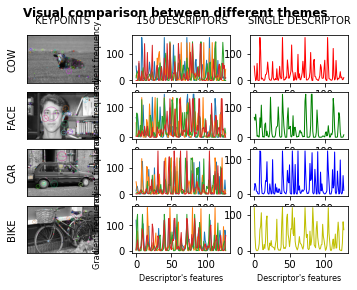

In [10]:
visualize(example_descriptors)

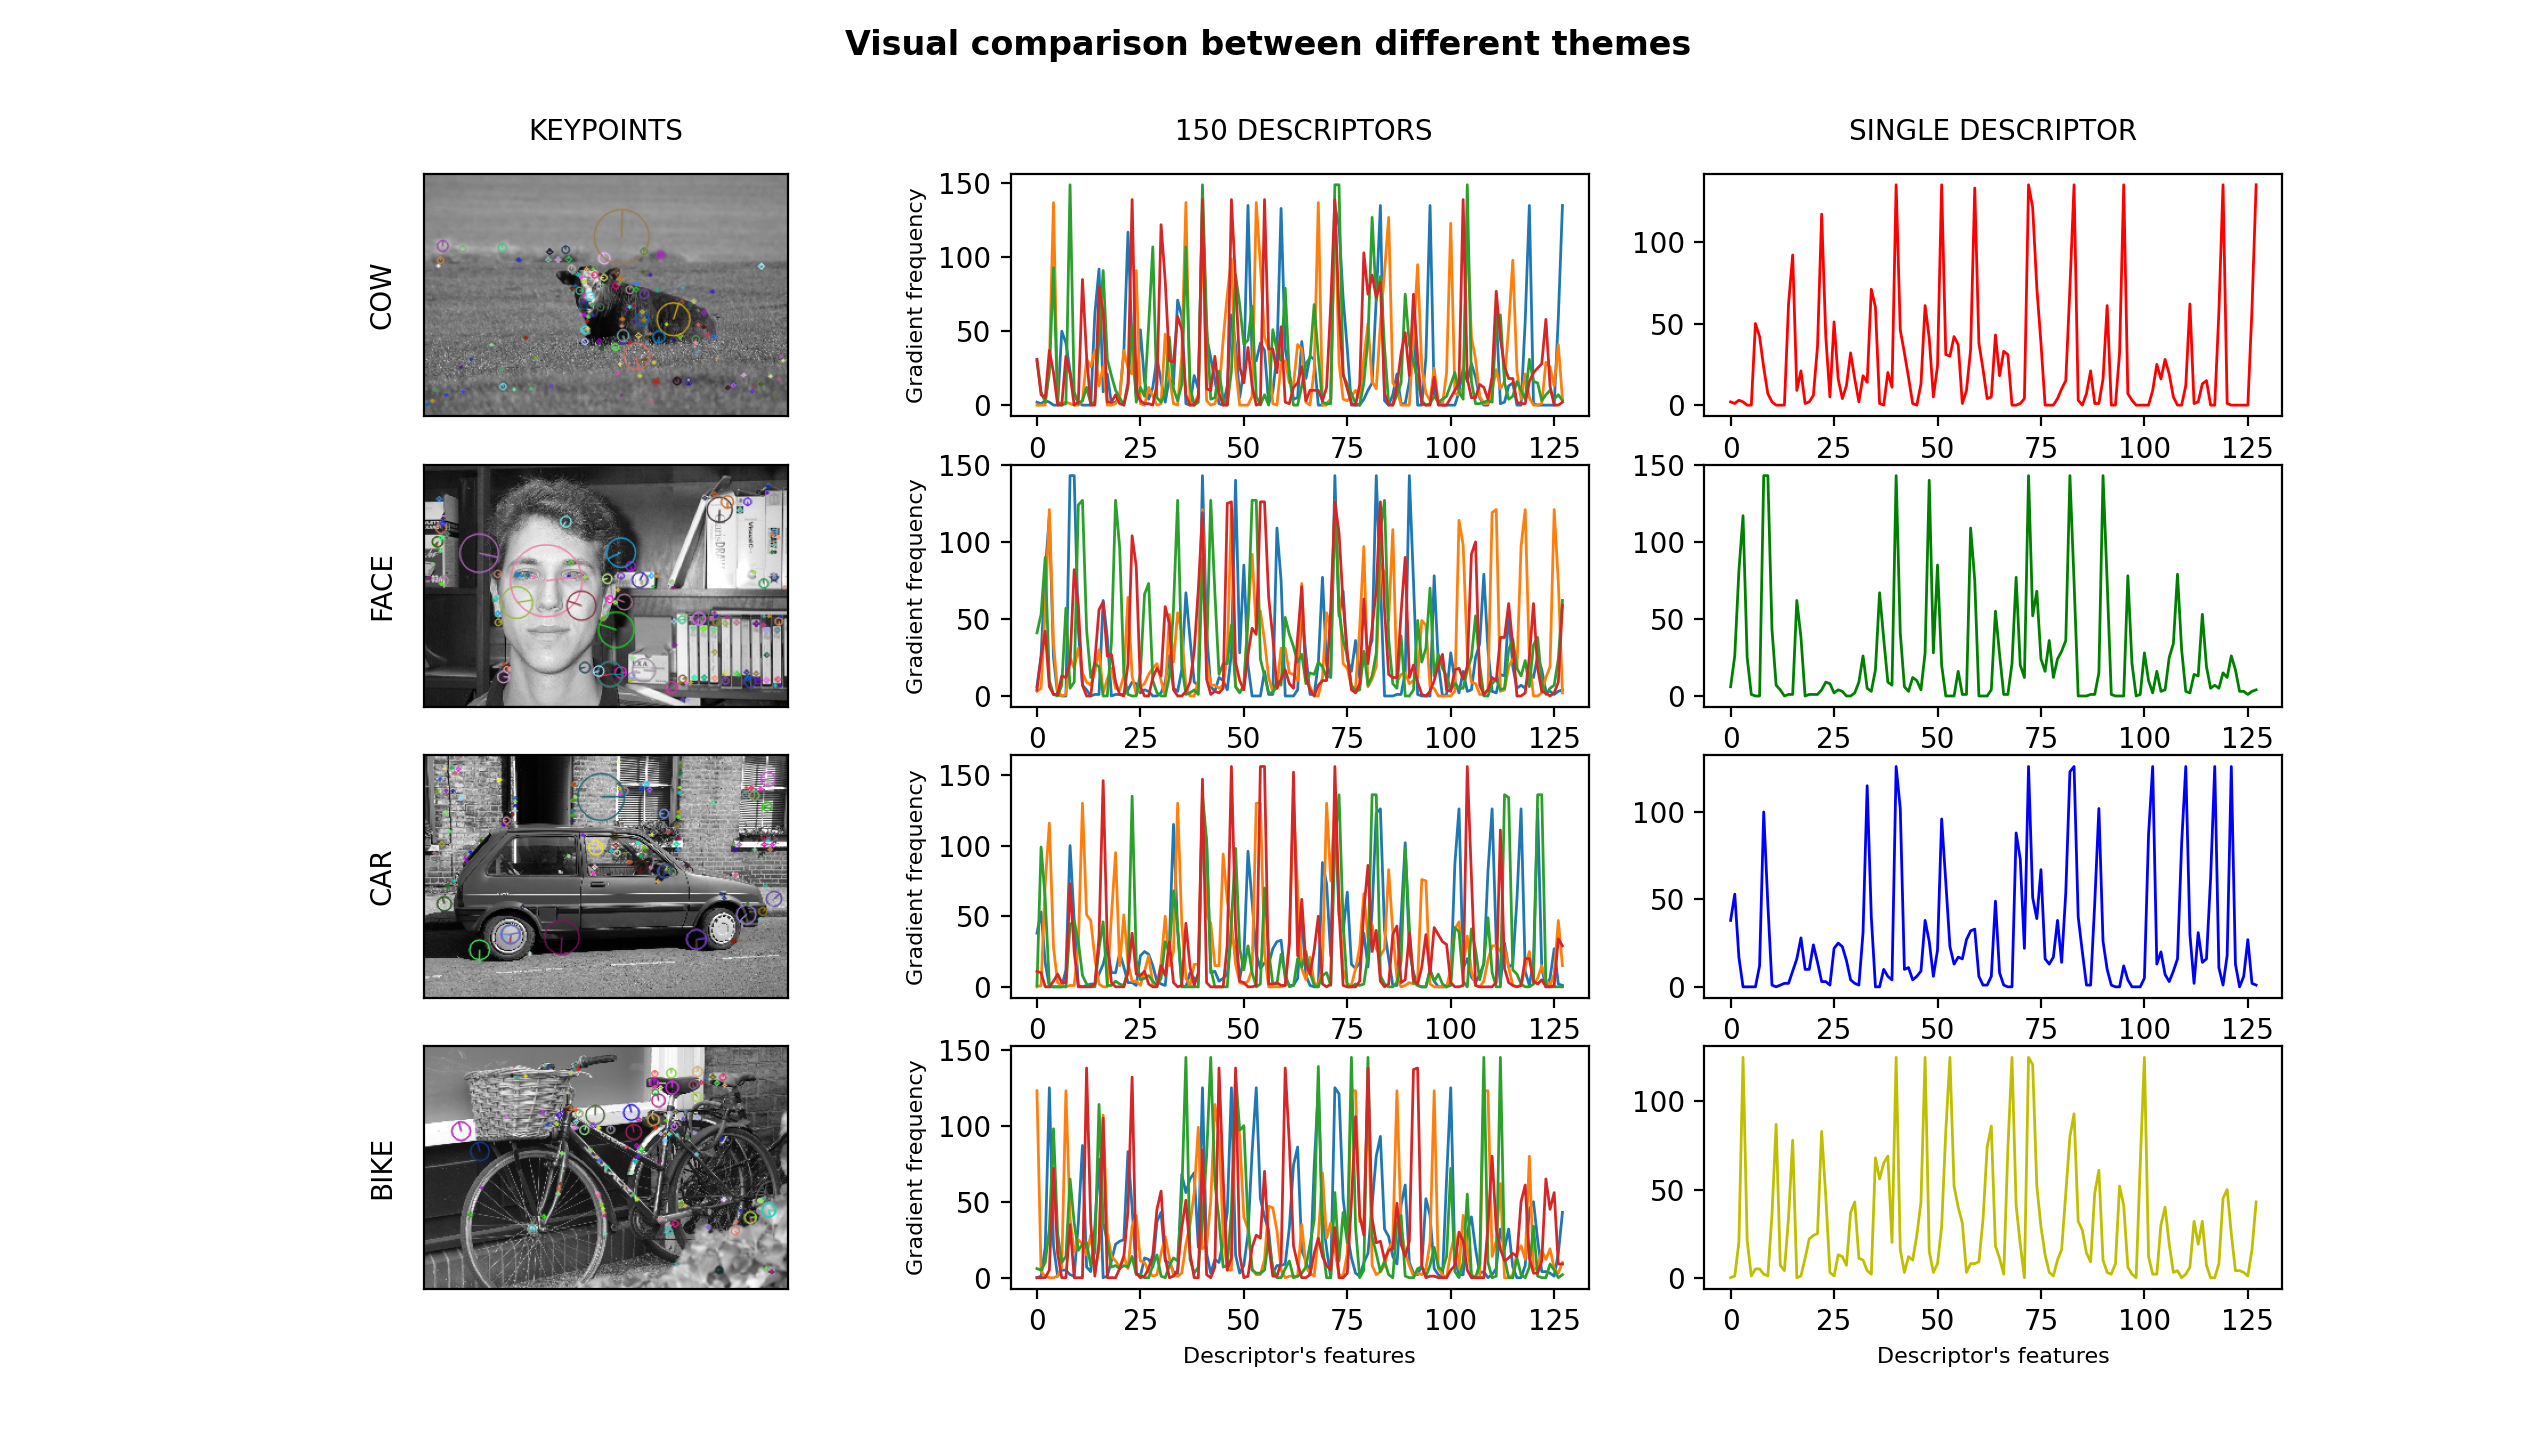



---



## **3. Clustering with K-Means**

In [30]:
def findNumCluster(dataset):
	
	#best_k = 4 # default k value
	test_k = range (5 , 15) # range of k values to be tested

	#find best value of k with SILHOUETTE METHOD
	silhouette = {}
	for k in test_k: 
    # for each value of k to be tested run k-means
		kmeans = KMeans(n_clusters=k).fit(dataset)
		labels_k = kmeans.labels_
    # compute silhoette scores and store it
		score_k = metrics.silhouette_score(dataset, labels_k)
		silhouette[k] = score_k
	# showsilhouette score by increasing k value
	plt.figure(figsize=(16,8))
	plt.plot(test_k, list(silhouette.values()), 'bx-')
	plt.xlabel('k')
	plt.ylabel('Silhouette')
	plt.title('Silhouette Method to find optimal k')
	plt.show()
  
  # the best k value is the one for which the silhouette score is maximaized
	best_k = max(silhouette, key=silhouette.get)
 
	return best_k

def generateCluster(dataset, k):
	
  # if k value is not given find it with silhouette method
	if k == None:
		k = findNumCluster(dataset)
		print("The best value of k founded is:", k)

  # use k-means alghorithm to cluster dataset 
	kmeans = KMeans(n_clusters=k).fit(dataset)
	centroids = kmeans.cluster_centers_
	labels = kmeans.labels_

	return labels

In [16]:
computed_labels = generateCluster(dataset, k=4)
print("", label)
print("", computed_labels)

# show dataset as dataframe
dataset = pd.DataFrame(dataset)
dataset["cluster"] = computed_labels # add to each descriptors its cluster 
dataset["theme"]   = label # add to each descriptors its thema 

print(dataset)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


 [2. 0. 3. ... 0. 1. 2.]
 [1 2 1 ... 1 1 1]
          0      1     2     3      4     5     6     7      8      9  ...  \
0       0.0   21.0  59.0   1.0    0.0  10.0  78.0   5.0    1.0   29.0  ...   
1      16.0  109.0  65.0   2.0    0.0   0.0   0.0   0.0   31.0   63.0  ...   
2      46.0   19.0   1.0   1.0   11.0  27.0  17.0  69.0   44.0    2.0  ...   
3      11.0    0.0   1.0   3.0    0.0   0.0   0.0  31.0   13.0    0.0  ...   
4      27.0    3.0   0.0   4.0  141.0  14.0   0.0   2.0  141.0   26.0  ...   
...     ...    ...   ...   ...    ...   ...   ...   ...    ...    ...  ...   
12009   0.0    1.0  31.0  31.0    2.0   3.0  25.0   6.0   11.0    2.0  ...   
12010   4.0   39.0  31.0   5.0   10.0   1.0   1.0   4.0   14.0  102.0  ...   
12011  43.0   43.0   8.0   1.0    3.0   5.0  31.0  65.0   92.0  124.0  ...   
12012   0.0    3.0  35.0  18.0   23.0  16.0  66.0  39.0    9.0    5.0  ...   
12013  23.0    1.0   0.0   0.0    0.0   0.0   5.0   8.0   40.0    8.0  ...   

         120    121

### **3.1. Find best value of k with silhouette method**

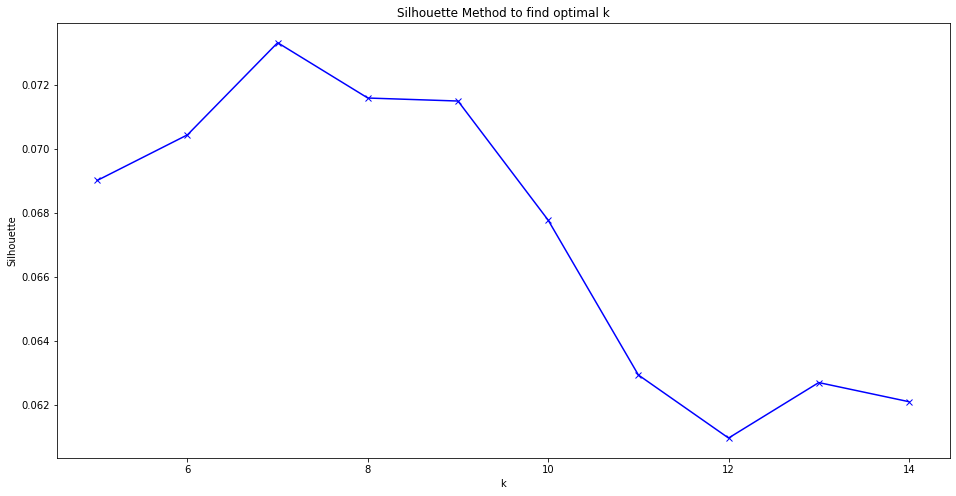

The best value of k founded is: 7
7


In [36]:
computed_labels_k = generateCluster(dataset, k=None)

# show dataset as dataframe
dataset_k = pd.DataFrame(dataset)
dataset_k["cluster"] = computed_labels_k # add to each descriptors its cluster 
dataset_k["theme"]   = label # add to each descriptors its thema 


## **4. Results analysis: comparison between obtained clusters and initial themes**

In [20]:
def computeConfusionMatrix(dataset):

  # compute confusion matrix 
	confusion_matrix = pd.crosstab(dataset["cluster"], dataset["theme"])
  # show confusion matrix 
	ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt="g")
	ax.set_title('Confusion Matrix\n\n');
	ax.set_xlabel('Actual Theme')
	ax.set_ylabel('Predicted Cluster');
	ax.xaxis.set_ticklabels(['Cow', 'Face', 'Car' , 'Bike'])
	#ax.yaxis.set_ticklabels(['cluster 1' , 'cluster 2', 'cluster 3' , 'cluster 4'])
	plt.show()

	return confusion_matrix 


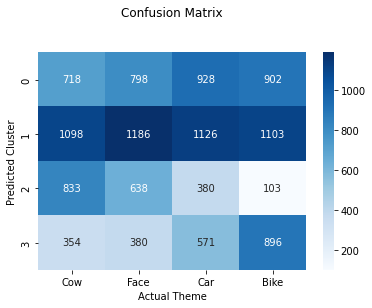

theme     0.0   1.0   2.0   3.0
cluster                        
0         718   798   928   902
1        1098  1186  1126  1103
2         833   638   380   103
3         354   380   571   896


In [21]:
confusionMatrix = computeConfusionMatrix(dataset)
print(confusionMatrix)

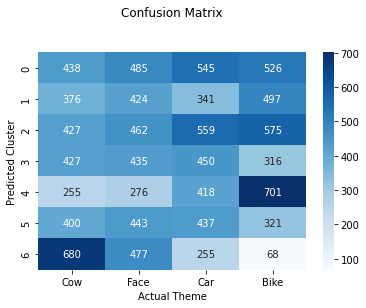

theme    0.0  1.0  2.0  3.0
cluster                    
0        438  485  545  526
1        376  424  341  497
2        427  462  559  575
3        427  435  450  316
4        255  276  418  701
5        400  443  437  321
6        680  477  255   68


In [32]:
confusionMatrix_k = computeConfusionMatrix(dataset_k)
print(confusionMatrix_k)

In [22]:
def computeCorrelationMatrix(dataset):
	
	random_test=50
	theme_value   = dataset["theme"].nunique()
	cluster_value = dataset["cluster"].nunique()
	correlation_matrix = np.zeros((cluster_value, theme_value))

	for k in range(0, random_test): 
		
		for i in range(0, cluster_value):
			for j in range(0, theme_value):
				
				des1 = dataset.loc[dataset["cluster"]==i]
				des2 = dataset.loc[dataset["theme"]==j]
				rand_des1 = np.array(des1.sample(), dtype="float32")
				rand_des2 = np.array(des2.sample(), dtype="float32")
				
				correlation = cv2.compareHist(rand_des1[0][0:-2], rand_des2[0][0:-2], cv2.HISTCMP_CORREL)
				correlation_matrix[i][j] += correlation
	
	correlation_matrix = correlation_matrix/random_test
			
	return correlation_matrix

In [34]:
correlation_matrix = computeCorrelationMatrix(dataset)
print(correlation_matrix)


[[0.14336951 0.15670365 0.14311803 0.16491507]
 [0.16606083 0.20465236 0.17947122 0.20034422]
 [0.12145403 0.09235727 0.07585705 0.15835852]
 [0.12629523 0.15639067 0.11970855 0.12387832]
 [0.16017478 0.17967672 0.15500142 0.27856215]
 [0.14898068 0.13203009 0.11251065 0.06994258]
 [0.28160994 0.2320163  0.27165974 0.25700461]]


## **5. Conclusions and further developments**

conclusioni 

approfondimenti 
* studiare il diverso comportamento ottenuto estrando più o meno descriptor per ognni immagine fixed a 200
* studiare il comportamento dei cluster con k>>100
* paragonnare i descriptors dei clusteer con quelli dei temi con altre metriche 



## **6. Source**


* [Collection of images](http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip)
*   [Scikit Learn, clustering with K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
*   [Scikit Learn, Selecting the number of clusters with silhouette analysis on KMeans clustering](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
*   [OpenCV, Histogram comparison](https://docs.opencv.org/3.4/d8/dc8/tutorial_histogram_comparison.html)
*   [OpenCV, SIFT](https://docs.opencv.org/3.4/d7/d60/classcv_1_1SIFT.html)
*   [OpenCV, SIFT extractor and detector](https://docs.opencv.org/3.4/d5/d51/group__features2d__main.html#ga89ce54823df44e7be4e43511c1d44553)